<a href="https://colab.research.google.com/github/Lanxin-Xiang/is765/blob/main/W8_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W8.Topic Modeling

Ref: https://radimrehurek.com/gensim/models/ldamodel.html

## Load data

We are still going to use the yelp comment data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #, force_remount=True)

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/is765

/content/drive/MyDrive/is765


In [ ]:
text_yelp = []
for line in open("data/sentiment labelled sentences/yelp_labelled.txt"):
    line = line.rstrip('\n').split('\t')
    text_yelp.append(line[0])

In [ ]:
%cd //content

/content


## Word Cloud

In the following code, we only demonstrate how to create a basic word cloud. However, you can generate word clouds of any shape and with wanted weights other than word frequency.


https://www.geeksforgeeks.org/generate-word-clouds-of-any-shape-in-python/

https://www.geeksforgeeks.org/generating-word-cloud-in-python-set-2/

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

%matplotlib inline

**Prepare text data and count words**

[`simple_preprocess`](https://tedboy.github.io/nlps/generated/generated/gensim.utils.simple_preprocess.html) is a tool to convert a document into a list of tokens. This lowercases, tokenizes, de-accents (optional) the document.

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = stopwords.words('english') # edit your own sopwords here.

In [ ]:
def get_count(data):
  unigram_counter = Counter()

  for text in data:
    words = simple_preprocess(text)
    words_nostops = [word for word in words if word not in stop_words]
    unigrams = unigram_counter.update(words_nostops)
  return unigram_counter

In [ ]:
word_count = get_count(text_yelp)

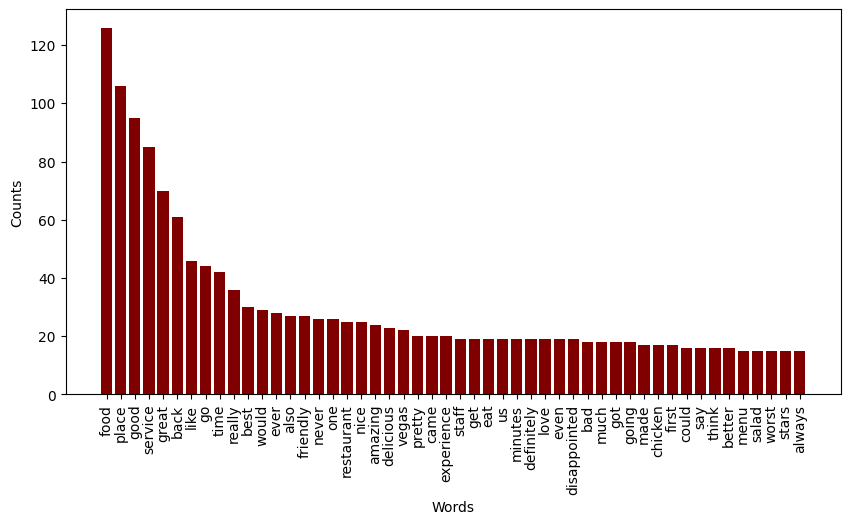

In [ ]:
# visualize the most frequent words
tp = word_count.most_common(50)
w = [item[0] for item in tp]
ct = [item[1] for item in tp]

plt.figure(figsize=(10, 5))
plt.bar(w, ct, color='maroon')
plt.xticks(rotation=90)
plt.xlabel("Words")
plt.ylabel("Counts")
plt.show()

**Generate Word Cloud**

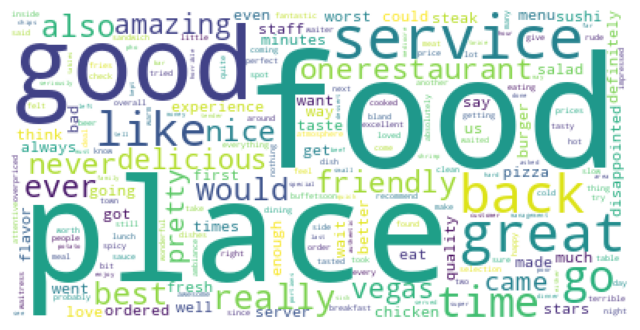

In [ ]:
plt.figure(figsize=(8, 6))

Cloud = WordCloud(background_color="white", max_words=300).generate_from_frequencies(dict(word_count.most_common(200)))
plt.imshow(Cloud)
plt.axis("off")
plt.show()

## Latent Dirichlet Analysis

**Prepare text data**

In [ ]:
import gensim
import gensim.corpora as corpora
import spacy
from gensim.models import CoherenceModel

In [ ]:
def sent_to_words(sentences):
  for sentence in sentences:
    yield(simple_preprocess(str(sentence), deacc=True))

In [ ]:
# Define function for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [ ]:
def lemmatization(texts, nlp, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
def prepare_text(data):

  words = list(sent_to_words(data))

  # Remove Stop Words
  words_nostops = remove_stopwords(words)

  # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
  # python3 -m spacy download en
  nlp = spacy.load("en_core_web_sm")

  # Do lemmatization keeping only noun, adj, vb, adv
  lemmatized = lemmatization(words_nostops, nlp, allowed_postags=['NOUN', 'ADV', 'ADJ', 'VERB'])
  # Create Dictionary
  id2word = corpora.Dictionary(lemmatized)
  # Create Corpus
  texts = lemmatized
  # Term Document Frequency
  corpus = [id2word.doc2bow(text) for text in texts]

  return lemmatized, id2word, corpus

**An example about what the spacy models do**

In [ ]:
nlp = spacy.load("en_core_web_sm")
doc = nlp("how you doing")
for token in doc:
  print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
        token.shape_, token.is_alpha, token.is_stop)

**We devide the data to two parts, one for training the model, the other one will be used to demonstrate how to update the LDA model**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(text_yelp, test_size=0.1, random_state=1)

**In order to train the LDA model, we are required to transform the text data to lemmantized document, an id2word dictionary and the term-document-frequency data**

In [ ]:
lemmatized, id2word, corpus = prepare_text(train)

In [ ]:
train[:5]

['Great service and food.',
 'I tried the Cape Cod ravoli, chicken,with cranberry...mmmm!',
 'Very, very sad.',
 'this was a different cut than the piece the other day but still wonderful and tender s well as well flavored.',
 'Strike 2, who wants to be rushed.']

In [ ]:
lemmatized[:5]

[['great', 'service', 'food'],
 ['try', 'cape', 'cod', 'ravoli', 'chicken'],
 ['sad'],
 ['different',
  'cut',
  'piece',
  'day',
  'still',
  'wonderful',
  'tender',
  'well',
  'well',
  'flavor'],
 ['strike', 'rush']]

In [ ]:
corpus[:5]

[[(0, 1), (1, 1), (2, 1)],
 [(3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(8, 1)],
 [(9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 2),
  (17, 1)],
 [(18, 1), (19, 1)]]

In [ ]:
# Build LDA model
def generate_lda_model(cn_lemmatized, id2word, corpus, num_topics):
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
  doc_lda = lda_model[corpus]

  print('\nPerplexity: ', lda_model.log_perplexity(corpus))

  coherence_model_lda = CoherenceModel(model=lda_model, texts=cn_lemmatized, dictionary=id2word, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  print('\nCoherence Score: ', coherence_lda)

  return lda_model, lda_model.log_perplexity(corpus), coherence_lda

In [ ]:
lda_model, perplexity, coherence = generate_lda_model(lemmatized, id2word, corpus, num_topics=5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -7.198434360861249

Coherence Score:  0.581711108242286


Let us take a look at what are the topics consist of and visualize with [`pyLDAvis`](https://pyldavis.readthedocs.io/en/latest/readme.html) to assist further analysis.

In [ ]:
lda_model.print_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.030*"love" + 0.016*"always" + 0.014*"recommend" + 0.013*"way" + 0.013*"menu" + 0.012*"cold" + 0.011*"breakfast" + 0.011*"friend" + 0.011*"customer" + 0.010*"rude"'),
 (1,
  '0.052*"back" + 0.038*"go" + 0.024*"wait" + 0.020*"get" + 0.020*"come" + 0.018*"eat" + 0.017*"definitely" + 0.016*"server" + 0.013*"try" + 0.012*"take"'),
 (2,
  '0.088*"place" + 0.028*"amazing" + 0.022*"think" + 0.022*"star" + 0.013*"awesome" + 0.012*"pretty" + 0.011*"well" + 0.011*"give" + 0.010*"burger" + 0.010*"vegas"'),
 (3,
  '0.067*"food" + 0.065*"good" + 0.047*"service" + 0.036*"time" + 0.032*"great" + 0.018*"really" + 0.017*"make" + 0.016*"bad" + 0.016*"go" + 0.016*"also"'),
 (4,
  '0.023*"friendly" + 0.023*"restaurant" + 0.023*"taste" + 0.017*"meal" + 0.016*"staff" + 0.016*"want" + 0.015*"dish" + 0.015*"fry" + 0.015*"order" + 0.015*"fresh"')]

In [ ]:
!pip install --upgrade pandas

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis

In [ ]:
# If failed, restart runtime and try again

lda_display = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**How to read the plot?**

- Left side: Each bubble represents a topic. The larger the bubble, the higher percentage of the number of documents in the corpus is about that topic. The further the bubbles are away from each other, the more different they are.

- Right side: Blue bars represent the overall frequency of each word in the corpus. If no topic is selected, the blue bars of the most frequently used words will be displayed. Red bars give the estimated number of times a given term was generated by a given topic. The word with the longest red bar is the word that is used the most by the document belonging to that topic.


- Topic 1: Food
- Topic 2: Restaurant
- Topic 3: Service
- Topic 4: Atmosphere
- Topic 5: Experience

In [ ]:
_, _, corpus_update = prepare_text(test) # here we only need the corpus of the new data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
vector = lda_model[corpus_update]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topics = [vector[i][0] for i in range(100)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topics[:5]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(0, 0.07481654),
  (1, 0.08124924),
  (2, 0.09272024),
  (3, 0.67316926),
  (4, 0.07804475)],
 [(0, 0.03748899),
  (1, 0.16962141),
  (2, 0.5399254),
  (3, 0.21384853),
  (4, 0.03911566)],
 [(0, 0.022980435),
  (1, 0.024958072),
  (2, 0.33882484),
  (3, 0.20747878),
  (4, 0.40575787)],
 [(0, 0.051784184),
  (1, 0.054091457),
  (2, 0.0709676),
  (3, 0.11383808),
  (4, 0.7093187)],
 [(0, 0.16408375),
  (1, 0.16784161),
  (2, 0.41731715),
  (3, 0.21170415),
  (4, 0.039053362)]]

In [ ]:
lda_model.update(corpus_update)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lda_display = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
